In [145]:
#wine
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from sklearn import tree
import graphviz

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

#load data
df = pd.read_csv (r'./data/wine.csv')

#preprocessing
# convert target to binary
df.loc[df.quality =='bad', "quality"] = 0 #bad wine
df.loc[df.quality == 'good', "quality"] = 1 #good wine
#get the target
y = df.pop('quality')
#scale features
X_scaled = preprocessing.scale(df)

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [80]:
#grid search to find best paramteres
params = {'alpha': [0.00001,0.0001,0.001]
          #epochs
          , 'max_iter': [12,15,17,20,23,27]
          , 'hidden_layer_sizes' : [(8,),(10,),(11,),(12,),(14,)]
                      }
grid_search_cv = GridSearchCV(MLPClassifier(random_state = 42, solver = 'lbfgs')
                              , params
                              , scoring = "accuracy"
                              , verbose=1
                              , cv=5
                              ,n_jobs=5)
grid_search_cv.fit(X_train, y_train);

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 450 out of 450 | elapsed:   10.0s finished


In [81]:
print("Best estimators: ", grid_search_cv.best_estimator_)

Best estimators:  MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [82]:
#model with default features. note we are using lbfgsand not default to avoid long runs.
print("ANN with default params accuracy: ", cross_val_score(MLPClassifier(solver = 'lbfgs',random_state = 42), X_train, y_train, cv=5, scoring='accuracy').mean())
print("ANN with tuned hyper paramaters accuracy: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='accuracy').mean())

ANN with default params accuracy:  0.7365165441176471
ANN with tuned hyper paramaters accuracy:  0.760765931372549


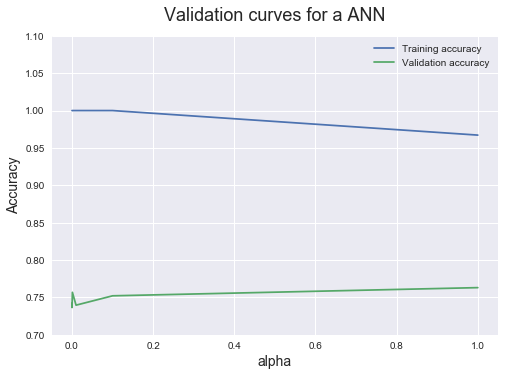

In [7]:
#plot validation curve
alpha_range = [0.00001, 0.0001,0.001,0.01,0.1,1]
train_scores, valid_scores = validation_curve(MLPClassifier(solver = 'lbfgs'
                                                            ,random_state = 42
                                                           #,hidden_layer_sizes=(12,)
                                                           #, max_iter = 20
                                                           ),
                                              X_train,
                                              y_train,
                                              param_name = "alpha",
                                              param_range = alpha_range,
                                              scoring='accuracy',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(alpha_range, train_scores.mean(axis=1), label = 'Training accuracy')
plt.plot(alpha_range, valid_scores.mean(axis=1), label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('alpha', fontsize = 14)
plt.title('Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.7,1.1)
plt.show()

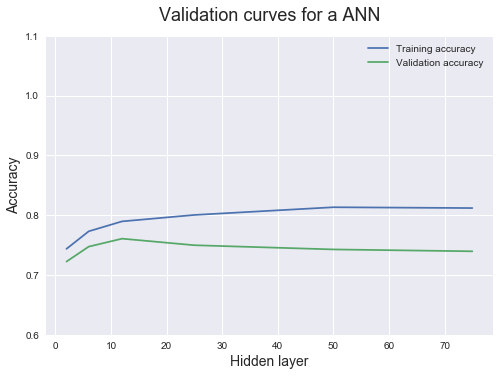

In [13]:
#plot validation curve
#1. number of nodes in 1 layer NN.


hidden_layer_range = [(2,),(6,),(12,),(25,),(50),(75,)]
hidden_layer = [2,6,12,25,50,75]
train_scores, valid_scores = validation_curve(MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False),
                                              X_train,
                                              y_train,
                                              param_name = "hidden_layer_sizes",
                                              param_range = hidden_layer_range,
                                              scoring='accuracy',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(hidden_layer, train_scores.mean(axis=1), label = 'Training accuracy')
plt.plot(hidden_layer, valid_scores.mean(axis=1), label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Hidden layer', fontsize = 14)
plt.title('Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.6,1.1)
plt.show()

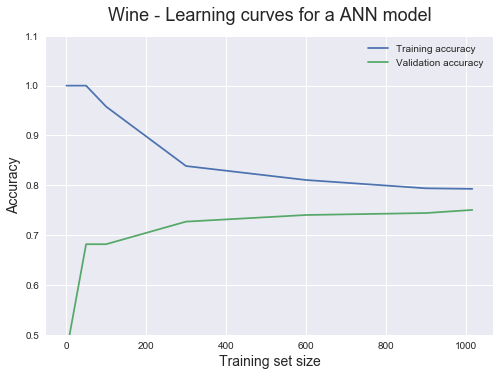

In [9]:
#learning curve

train_sizes = [1,50, 100, 300, 600, 900, 1016]

train_sizes, train_scores, validation_scores = learning_curve(
               estimator = grid_search_cv.best_estimator_,
               X = X_train,
               y = y_train,
               train_sizes = train_sizes,
               cv = 5,
               scoring = 'accuracy')

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Wine - Learning curves for a ANN model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.5,1.1)
plt.show()

In [72]:
#diabetes
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

from sklearn import tree

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.neural_network import MLPClassifier

#load data
df = pd.read_csv (r'./data/diabetes.csv')

#preprocessing
# convert target to binary
df.loc[df["class"] =='tested_negative', "class"] = 0
df.loc[df["class"] == 'tested_positive', "class"] = 1

#get the target
y = df.pop('class')
#scale features
X_scaled = preprocessing.scale(df)

oversample = BorderlineSMOTE(random_state=42)
X_scaled, y = oversample.fit_resample(X_scaled, y)


#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [73]:
#grid search to find best paramteres
params = {'alpha': [0.00001,0.0001,0.001]
                        , 'max_iter': [12,15,17,20,23,27,50,100]
                        , 'hidden_layer_sizes' : [(8,),(10,),(11,),(12,),(14,),(7,7),(12,12),(25,25)]
                      }
grid_search_cv = GridSearchCV(MLPClassifier(solver = 'lbfgs',random_state = 42)
                              , params
                              , scoring = "f1"
                              , verbose=1
                              , cv=5
                              ,n_jobs=5)
grid_search_cv.fit(X_train, y_train);

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 325 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 825 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 951 out of 960 | elapsed:   25.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 960 out of 960 | elapsed:   26.5s finished


In [74]:
print("Best estimators: ", grid_search_cv.best_estimator_)

Best estimators:  MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 12), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=17,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [52]:
#model with default features
print("ANN with default params f1: ", cross_val_score(MLPClassifier(), X_train, y_train, cv=5, scoring='f1').mean())
print("ANN with tuned hyper paramaters f1: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='f1').mean())

ANN with default params f1:  0.7687448397711473
ANN with tuned hyper paramaters f1:  0.7829315375521251


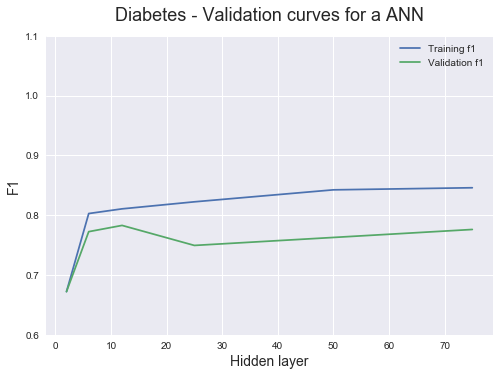

In [75]:
#plot validation curve
#1. number of nodes in 1 layer NN.


#hidden_layer_range = [(2,),(6,),(12,),(25,),(50),(75,)]
hidden_layer_range = [(2,2),(6,6),(12,12),(25,25),(50,50),(75,75)]
hidden_layer = [2,6,12,25,50,75]
train_scores, valid_scores = validation_curve(MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
               learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=17,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False),
                                              X_train,
                                              y_train,
                                              param_name = "hidden_layer_sizes",
                                              param_range = hidden_layer_range,
                                              scoring='f1',
                                             cv=5)

plt.style.use('seaborn')
plt.plot(hidden_layer, train_scores.mean(axis=1), label = 'Training f1')
plt.plot(hidden_layer, valid_scores.mean(axis=1), label = 'Validation f1')
plt.ylabel('F1', fontsize = 14)
plt.xlabel('Hidden layer', fontsize = 14)
plt.title('Diabetes - Validation curves for a ANN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.6,1.1)
plt.show()

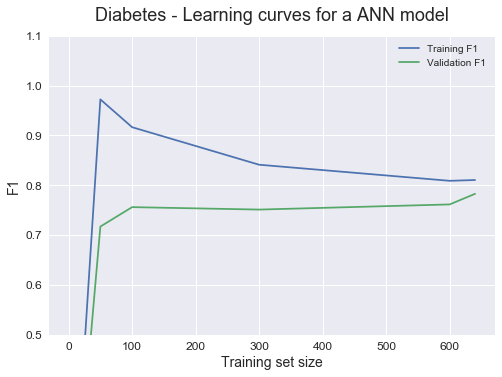

In [78]:
#learning curve

train_sizes = [1,50, 100, 300, 600, 640]

train_sizes, train_scores, validation_scores = learning_curve(
               estimator = grid_search_cv.best_estimator_,
               X = X_train,
               y = y_train,
               train_sizes = train_sizes,
               cv = 5,
               scoring = 'f1')

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
#print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
#print('\n', '-' * 20) # separator
#print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training F1')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation F1')
plt.ylabel('F1', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Diabetes - Learning curves for a ANN model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.5,1.1)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

In [77]:
#model with default features
print("ANN with default params F1: ", cross_val_score(MLPClassifier(random_state=42), X_train, y_train, cv=5, scoring='f1').mean())
print("ANN with tuned hyper paramaters F1: ", cross_val_score(grid_search_cv.best_estimator_, X_train, y_train, cv=5, scoring='f1').mean())
#print("ANN with tuned LC paramaters F1: ", cross_val_score(mlp_dia, X_train, y_train, cv=5, scoring='f1').mean())

ANN with default params F1:  0.7664146859701416
ANN with tuned hyper paramaters F1:  0.7829315375521251


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
np.random.seed(1)




mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, #solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""

N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 25
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        print(indices)
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))

    epoch += 1

""" Plot """
plt.plot(scores_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

epoch:  0
[ 133  655  395  248  969   60  863  881 1213  459  236  325  582 1219
  231  453  936  573   75 1068  797  700 1234  868 1178  692  991  629
 1153   81  259  950 1217 1029  255 1101 1011  736  177  301  195  216
  780 1084  675 1215  341  908  135  131  604  258  932  201  422   65
 1121  268  428 1126  163 1226  956  686 1182  694   88  408  107  529
  409  577 1103  108  576  674  820  401 1027  280  757  493  181 1091
  904  790 1186  119 1097 1242 1048  309  972  336   12  375  892  647
  708  909  190  350  725  920   49  581  982  636  111 1136  556  995
 1181  142  783  650 1113  283  958  671 1066  926  473 1060 1262 1231
 1062  404]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [87]:
X_train.shape[0]

1279

In [89]:
np.random.permutation(X_train.shape[0]).size

1279

In [98]:
np.unique(y_train)
pip install fetch_mldata

SyntaxError: invalid syntax (<ipython-input-98-935ae0fc6bc9>, line 2)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24


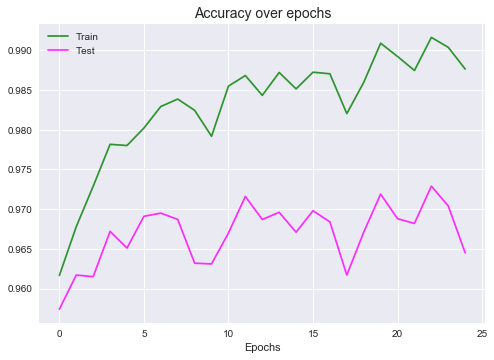

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
np.random.seed(1)

""" Example based on sklearn's docs """
mnist = fetch_openml('mnist_784', version=1, cache=True)
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-8, random_state=1,
                    learning_rate_init=.01)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 25
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))

    epoch += 1

""" Plot """
plt.plot(scores_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

In [109]:
mnist.data.shape

(70000, 784)

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
np.random.seed(1)



mlp = mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, #solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 10
N_BATCH = 10
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []
indices = []
# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        print(mini_batch_index)
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        print(indices)
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))

    epoch += 1

""" Plot """
plt.plot(scores_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

epoch:  0
0
[ 133  655  395  248  969   60  863  881 1213  459]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [119]:
mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, #solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
mlp.partial_fit(X_train, y_train, np.unique(y_train))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [124]:
np.random.permutation(X_train.shape[0])[0:100]

array([ 467,  960,  130,  577, 1098,    6,  103,   79, 1247, 1139,  525,
        396,  824,  173,   74,  662,  138,  298,  183,  335,  729,  486,
         81,  342,  315, 1228,  781,  214, 1128, 1174,    9,  606,  692,
       1065,  286,  471,    5,  964, 1157, 1000,  428, 1164,   14,  965,
       1009,  408,  526,  418,  291,  379, 1146,  622,  667, 1135,  933,
        914, 1184, 1066,  567,  434,  738,  237,  745,  860,  432,  636,
        587,  243,  605,  581,  440,  803, 1256,  701,   75,  406, 1169,
       1257,  530,  495,  194,  565,  473,  337,  469, 1093,  812,  903,
        430,  825,  288,  325,  555,  506,  784,  817, 1125, 1017,   55,
        355])

In [143]:
np.all(np.isfinite(X_train))

True

In [138]:
mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, #solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [142]:
X_train[~np.isfinite(X_train)] = 0

In [146]:
np.isfinite(X_train)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [149]:
np.any(np.isnan(X_train))

False

In [150]:
np.all(np.isfinite(X_train))

True

In [152]:
print(X_train[:,0].shape)
index = 0
for i in X_train[:,0]:
    if np.isnan(i):
        print(index, i)
    index +=1

(1279,)


In [154]:
X_train.astype(np.float)

array([[ 0.9079665 ,  0.06804042,  0.91929852, ...,  0.51112954,
        -0.22512806, -0.96024611],
       [ 1.4250439 , -1.49617302,  0.91929852, ..., -1.17348276,
        -0.69723268, -0.77251161],
       [ 0.9079665 , -0.99339013,  1.43280314, ..., -0.33117661,
         0.77809425,  0.16616088],
       ...,
       [-0.24109439,  0.23563472,  0.20039205, ..., -0.13679827,
         0.18796348, -0.86637886],
       [ 2.68901088, -0.32301294,  1.12470036, ..., -0.07200549,
         0.1289504 ,  2.13737311],
       [ 0.85051346,  2.52609011,  0.25174251, ..., -0.39596939,
        -1.05131114, -0.96024611]])

In [167]:
X = X_train[133,655,395,248,969,60,863,881,1213,459]

IndexError: too many indices for array

In [166]:
 np.all(np.isnan(X_train[indices]))

False

In [168]:
if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [175]:
np.unique(y_train)

array([0., 1.])

In [170]:
y_train.dtype

dtype('int64')

In [172]:
y_train = y_train.astype(np.float)

In [173]:
y_train

642     0.0
679     0.0
473     0.0
390     1.0
1096    1.0
       ... 
763     0.0
835     0.0
1216    1.0
559     1.0
684     0.0
Name: quality, Length: 1279, dtype: float64

In [183]:
import time
x1= time.time()

In [184]:
x2 = time.time()

In [185]:
x2-x1

1.0229151248931885